In [14]:
import numpy as np
from numpy import sqrt, exp, pi, cos, sin, log, abs

from scipy.stats import norm, qmc
from tqdm import tqdm, trange
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from numba import njit

plt.style.use('dark_background')
plt.rcParams.update({'font.size': 14})
# np.random.seed(42)

# Heston Model Stochastic Differential Equations  

\begin{align*}
dS_t =& r S_t dt + \sqrt{v_t} S_t dW_t^S \\
dv_t =& \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW_t^v\\
dW_t^1 dW_t^2 =& \rho dt
\end{align*}
Where:
- $ S_t $: The asset price at time $ t $.
- $ \mu $: The drift rate of the asset price.
- $ v_t $: The instantaneous variance at time $ t $.
- $ \kappa $: The rate of mean reversion of the variance process.
- $ \theta $: The long-term mean variance.
- $ \sigma $: The volatility of volatility (vol of vol), measuring the variability of the variance process.
- $ W_t^S $: A standard Wiener process for $ S_t $
- $ W_t^v $: A standard Wiener process for $ v_t $
- $ \rho $: The correlation coefficient between $ W_t^S $ and $ W_t^v $.


# Moments CIR Process
## Analytical Moments  

\begin{align*}
\mathbb{E}[v_t] &= v_0 \exp(-\kappa T) + \theta (1 - \exp(-\kappa T)) \\
\mathbb{E}[v_t^2] &= v_0^2 \exp(-2 \kappa T) + \left(1 + \frac{1}{\gamma}\right) \left(\theta^2 (1 - \exp(-\kappa T))^2 + 2 v_0 \theta (\exp(-\kappa T) - \exp(-2 \kappa T))\right) \\
\mathbb{E}[v_t^3] &= v_0^3 e_{kt}^3 + \left(1 + \frac{3}{\gamma} + \frac{2}{\gamma^2}\right) \left(\theta^3 (1 - e_{kt})^3 + 3 v_0 \theta^2 (e_{kt} - 2 e_{kt}^2 + e_{kt}^3)\right) \\
&\quad + 3 v_0^2 \theta \left(1 + \frac{2}{\gamma}\right) (e_{kt} - e_{kt}^3) \\
\mathbb{E}[v_t^4] &= v_0^4 e_{kt}^4 + 6 v_0^2 \theta^2 \left(1 + \frac{5}{\gamma} + \frac{6}{\gamma^2}\right) (e_{kt}^2 - 2 e_{kt}^3 + e_{kt}^4) \\
&\quad + \left(1 + \frac{1}{\gamma} + \frac{11}{\gamma^2} + \frac{6}{\gamma^3}\right) \left(\theta^4 (1 - e_{kt})^4 + 4 v_0 \theta^3 (e_{kt} - 3 e_{kt}^2 + 3 e_{kt}^3 - e_{kt}^4)\right) \\
&\quad + 4 v_0^3 \theta \left(1 + \frac{3}{\gamma}\right) (e_{kt}^3 - e_{kt}^4) \\
\gamma &= \frac{2 \kappa \theta}{\sigma^2} \\
e_{kt} &= \exp(-\kappa T) \\
\end{align*}

## Numerical Moments  

\begin{align*}
\mathbb{E}[v_T^{(n)}] = & \frac{1}{N}\sum_{i=0}^N v_{(T,i)}^n \\
\end{align*}

## With Standard Error on the Numerical Moments  

$$
SE\left[\mathbb{E}[v_T]\right] = \frac{1}{\sqrt{128}} \sqrt{\frac{1}{127} \sum_{n=0}^{128} \left( \mathbb{E}[v_T]^{(n)} - \mathbb{E}[{v_T}] \right)^2}
$$

Where:

$$ \left\{\mathbb{E}[v_T]^{(n)}\right\}_{n=0}^{128} \text{ are non-overlapping subsets of the population.} $$

In [15]:
def moments_CIR(kappa, theta, sigma, T, v0):
    gamma = (2 * kappa*theta) / sigma**2
    e_kt = np.exp(-kappa * T)

    # First moment
    m1 = v0 * np.exp(-kappa * T) + theta * (1 - np.exp(-kappa * T))
    
    # Second moment
    m2 = (v0**2 * np.exp(-2 * kappa * T) + 
          (1 + 1/gamma) * 
          (theta**2*(1 - np.exp(-kappa * T))**2 + 2 * v0 * theta * (np.exp(-kappa * T) - np.exp(-2 * kappa * T))))
    
    # Third moment
    m3 = v0**3 * e_kt**3 + (1 + 3 * gamma**-1 + 2 * gamma**-2) * (theta**3 * (1 - e_kt)**3 + 3 * v0 * theta**2 * (e_kt - 2 * e_kt**2 + e_kt**3)) + 3 * v0**2 * theta * (1 + 2 * gamma**-1) * (e_kt - e_kt**3)
    
    # Fourth moment
    m4 = (v0**4 * e_kt**4 + 
          6 * v0**2 * theta**2 * (1 + 5 * gamma**-1 + 6 * gamma**-2) * (e_kt**2 - 2 * e_kt**3 + e_kt**4) + 
          (1 + gamma**-1 + 11 * gamma**-2 + 6 * gamma**-3) * (theta**4 * (1 - e_kt)**4 + 
          4 * v0 * theta**3 * (e_kt - 3 * e_kt**2 + 3 * e_kt**3 - e_kt**4)) + 
          4 * v0**3 * theta * (1 + 3 * gamma**-1) * (e_kt**3 - e_kt**4))
    
    # Variance
    Var = m2 - m1**2
    return m1, m2, m3, m4, Var


### Discretization and QE Method

To simulate the Heston model, we use a Quadratic Exponential (QE) scheme for variance $V_t$ and a log-normal process for the asset price $S_t$. The QE method approximates the conditional distribution of $V_t$ given $V_{t-1}$ by either a non-central chi-squared distribution or an exponential distribution, depending on a threshold value $\psi_C$.

#### Conditional Moments

First, we compute the conditional moments:

$$\begin{align*}  
m &= \theta + (V_{t-1} - \theta) e^{-\kappa \Delta t}, \\  
s^2 &= \frac{V_{t-1} \sigma^2 e^{-\kappa \Delta t}}{\kappa} (1 - e^{-\kappa \Delta t}) + \frac{\theta \sigma^2}{2 \kappa} (1 - e^{-\kappa \Delta t})^2,  
\end{align*}$$

where $\Delta t$ is the time step.

Next, we compute the threshold value $\psi$:

$$\psi = \frac{s^2}{m^2}.$$

#### Variance Update

If $\psi \leq \psi_C$, we use the non-central chi-squared distribution approximation:

$$\begin{align*}  
b &= \sqrt{\frac{2}{\psi} - 1 + \sqrt{\frac{2}{\psi} \left( \frac{2}{\psi} - 1 \right)}}, \\  
a &= \frac{m}{1 + b^2}, \\  
V_t &= a (b + Z_v)^2,  
\end{align*}$$

where $Z_v$ is a standard normal random variable.

If $\psi > \psi_C$, we use the exponential distribution approximation:

$$\begin{align*}  
p &= \frac{\psi - 1}{\psi + 1}, \\  
\beta &= \frac{1 - p}{m}, \\  
V_t &= \begin{cases}  
0 & \text{if } U_v \leq p, \\  
\frac{1}{\beta} \log \left( \frac{1 - p}{1 - U_v} \right) & \text{if } U_v > p,  
\end{cases}  
\end{align*}$$

where $U_v$ is a uniform random variable on [0, 1].

#### Asset Price Update

The asset price $S_t$ is updated using the log-normal process:

$$S_t = S_{t-1} \exp \left( (r - q) \Delta t + K_0 + K_1 V_{t-1} + K_2 V_t + \sqrt{K_3 V_{t-1} + K_4 V_t} \, Z_s \right),$$

where $Z_s$ is a standard normal random variable. The coefficients $K_0, K_1, K_2, K_3, K_4$ are defined to ensure the correct mean and variance.

#### Martingale Correction

When the martingale correction is applied, we adjust the asset price update as follows:

$$\begin{align*}  
M &= \exp(A V_t), \\  
K_0^* &= -\log(M) - (K_1 + 0.5 K_3) V_{t-1}, \\  
S_t &= S_{t-1} \exp \left( (r - q) \Delta t + K_0^* + K_1 V_{t-1} + K_2 V_t + \sqrt{K_3 V_{t-1} + K_4 V_t} \, Z_s \right).  
\end{align*}$$

This correction ensures that the process remains a martingale, preserving the no-arbitrage condition.

In [16]:
@njit
def process_simulation(S0, V0, dt, Martingale_Correction,
                       E, K0, K1, K2, K3, K4, A, Uv, Zv, Zs, theta, sigma, kappa, r, q, T_steps, psiC=1.5):
    S = np.zeros(T_steps+1, dtype=np.float32)
    V = np.zeros(T_steps+1, dtype=np.float32)
    S[0] = S0
    V[0] = V0

    for t in range(1, T_steps+1):
        m = theta + (V[t - 1] - theta) * E # Correct
        s2 = (V[t - 1] * sigma**2 * E)/kappa * (1 - E) + (theta * sigma**2)/(2 * kappa)*(1 - E)**2 # Correct
        psi = s2 / m ** 2

        if psi <= psiC:
            b = np.sqrt(2/psi - 1 + np.sqrt(2/psi * (2/psi - 1)))
            a = m / (1 + b**2)
            
            V[t] = a * (b + Zv[t]) ** 2

            if A > (1 / (2 * a)): print('Warning: A > 1 / (2 * a)') # Correct
            if Martingale_Correction and A < (1 / (2 * a)):
                # M = np.exp((A * b ** 2 * a) / (1 - 2 * A * a)) / np.sqrt(1 - 2 * A * a)
                M = np.exp(A*V[t]) # Correct
                K0_star = -np.log(M) - (K1 + 0.5*K3) * V[t-1] # Correct
                # K0_star = -(A*b**2*a)/(1-2*A*a) + .5*np.log(1 - 2*A*a) - (K1 + 0.5*K3) * V[t-1] # Correct

                S[t] = S[t - 1] * np.exp((r - q) * dt + K0_star + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t])
            else:
                S[t] = S[t - 1] * np.exp((r - q) * dt + K0      + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t])
            
        else:
            p = (psi - 1) / (psi + 1) # Correct
            beta = (1 - p) / m # Correct
            
            if Uv[t] <= p:
                phiinv = 0
            else:
                phiinv = 1 / beta * np.log((1 - p) / (1 - Uv[t]))

            V[t] = phiinv

            if A > beta: print('Warning: A > beta') # Correct
            if Martingale_Correction and A < beta:
                # M = p + b*(1-p)/(b - A)
                M = np.exp(A*V[t]) # Correct
                K0_star = -np.log(M) - (K1 + 0.5*K3) * V[t-1] # Correct
                # K0_star = -np.log(p + b*(1-p)/(b - A)) - (K1 + 0.5*K3) * V[t-1]

                S[t] = S[t - 1] * np.exp((r - q) * dt + K0_star + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t])
            else:
                S[t] = S[t - 1] * np.exp((r - q) * dt + K0      + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t])

    return S, V

def QESim(S0, V0, rho, theta, sigma, kappa, r, q, dt, T_steps, N_paths, psiC=1.5, gamma1=0.5, gamma2=0.5, Martingale_Correction=1):
    E = np.exp(-kappa * dt)
    K0 = -(kappa * rho * theta) / sigma * dt
    K1 = (kappa * rho / sigma - 1 / 2) * gamma1 * dt - rho / sigma
    K2 = (kappa * rho / sigma - 1 / 2) * gamma2 * dt + rho / sigma
    K3 = (1 - rho ** 2) * gamma1 * dt
    K4 = (1 - rho ** 2) * gamma2 * dt # Correct
    A = K2 + 0.5 * K4 # Correct
    
    print('>>Generating Sobol Numbers', end='\r')
    sobol_gen = qmc.Sobol(d=T_steps + 1)
    Uv = sobol_gen.random(n=N_paths)
    Us = sobol_gen.random(n=N_paths)
    Zv, Zs = norm.ppf(Uv), norm.ppf(Us) ; print('', end='\r')

    with parallel_backend('threading', n_jobs=-1):
        results = Parallel(n_jobs=-1)(delayed(process_simulation)(
            S0, V0, dt, Martingale_Correction,
            E, K0, K1, K2, K3, K4, A, Uv[i], Zv[i], Zs[i], theta, sigma, kappa, r, q, T_steps, psiC
        ) for i in tqdm(range(N_paths), desc="Simulating Paths"))

    S, V = zip(*results) ; del results
    return np.array(S), np.array(V)


In [17]:
def QESim(S0, V0, rho, theta, sigma, kappa, r, q, dt, T_steps, N_paths, psiC=1.5, gamma1=0.5, gamma2=0.5, Martingale_Correction=1):
    E = np.exp(-kappa * dt)
    K0 = -(kappa * rho * theta) / sigma * dt
    K1 = (kappa * rho / sigma - 1 / 2) * gamma1 * dt - rho / sigma
    K2 = (kappa * rho / sigma - 1 / 2) * gamma2 * dt + rho / sigma
    K3 = (1 - rho ** 2) * gamma1 * dt
    K4 = (1 - rho ** 2) * gamma2 * dt # Correct
    A = K2 + 0.5 * K4 # Correct
    
    # print('>>Generating Sobol Numbers', end='\r')
    sobol_gen = qmc.Sobol(d=T_steps + 1)
    Uv = sobol_gen.random(n=N_paths).T
    Us = sobol_gen.random(n=N_paths).T
    Zv, Zs = norm.ppf(Uv), norm.ppf(Us) #; print('', end='\n')

    S = np.zeros((T_steps+1, N_paths))
    V = np.zeros((T_steps+1, N_paths))

    S[0] = log(S0)
    V[0] = V0

    for t in trange(1, T_steps+1, desc="Simulating Paths", position=0, leave=False):
        m = theta + (V[t - 1] - theta) * E # Correct
        s2 = (V[t - 1] * sigma**2 * E)/kappa * (1 - E) + (theta * sigma**2)/(2 * kappa)*(1 - E)**2 # Correct
        psi = s2 / m ** 2

        idx = psi <= psiC
        # When psi <= psiC
        b = np.sqrt(2/psi[idx] - 1 + np.sqrt(2/psi[idx] * (2/psi[idx] - 1)))
        a = m[idx] / (1 + b**2)     
        V[t, idx] = a * (b + Zv[t, idx]) ** 2

        # When psi > psiC
        p = (psi[~idx] - 1) / (psi[~idx] + 1) # Correct
        beta = (1 - p ) / m[~idx]  # Correct
        idx2 = (Uv[t, ~idx] <= p)
        V[t, ~idx] = np.where(idx2, 0, 1 / beta * np.log((1 - p) / (1 - Uv[t, ~idx])))

        if Martingale_Correction:
            idx2 = A < (1 / (2 * a))
            M = np.exp(A*V[t])
            K0_star = -np.log(M) - (K1 + 0.5*K3) * V[t-1] # Correct
            # K0_star = -(A*b**2*a)/(1-2*A*a) + .5*np.log(1 - 2*A*a) - (K1 + 0.5*K3) * V[t-1] # Correct

            S[t] = S[t - 1] + (r - q) * dt + K0_star + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t]
        else:
            S[t] = S[t - 1] + (r - q) * dt + K0      + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t]
    
    S = exp(S).T
    V = V.T

    # Find if there are NaN values and replace those paths with S0
    idx = np.isnan(S).sum(axis=1) == 0
    if idx.sum() < N_paths :
        print(f"Warning: {N_paths - idx.sum()} paths removed due to NaN values and replaced with E[S_t] and E[V_t]")
        S[~idx] = S0*exp((r-q)*np.arange(T_steps+1)*dt)
        V[~idx] = V0 * np.exp(-kappa * np.arange(T_steps+1)*dt) + theta * (1 - np.exp(-kappa * np.arange(T_steps+1)*dt))

    return S, V

# S_T_array_QE, v_T_array_QE = QESim(S0=S0, V0=v0, rho=rho, theta=theta, sigma=sigma, kappa=kappa, r=r, q=q, dt=1,
#                      T_steps=10, N_paths=N_paths, Martingale_Correction=1)

Time step: 0.0100, Time Horizon: 1 years with 131072 paths and 100 steps


Simulating Paths:  38%|███▊      | 38/100 [00:00<00:00, 95.26it/s]/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_45171/4177653482.py:47: RuntimeWarning: invalid value encountered in multiply
  S[t] = S[t - 1] + (r - q) * dt + K0      + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t]


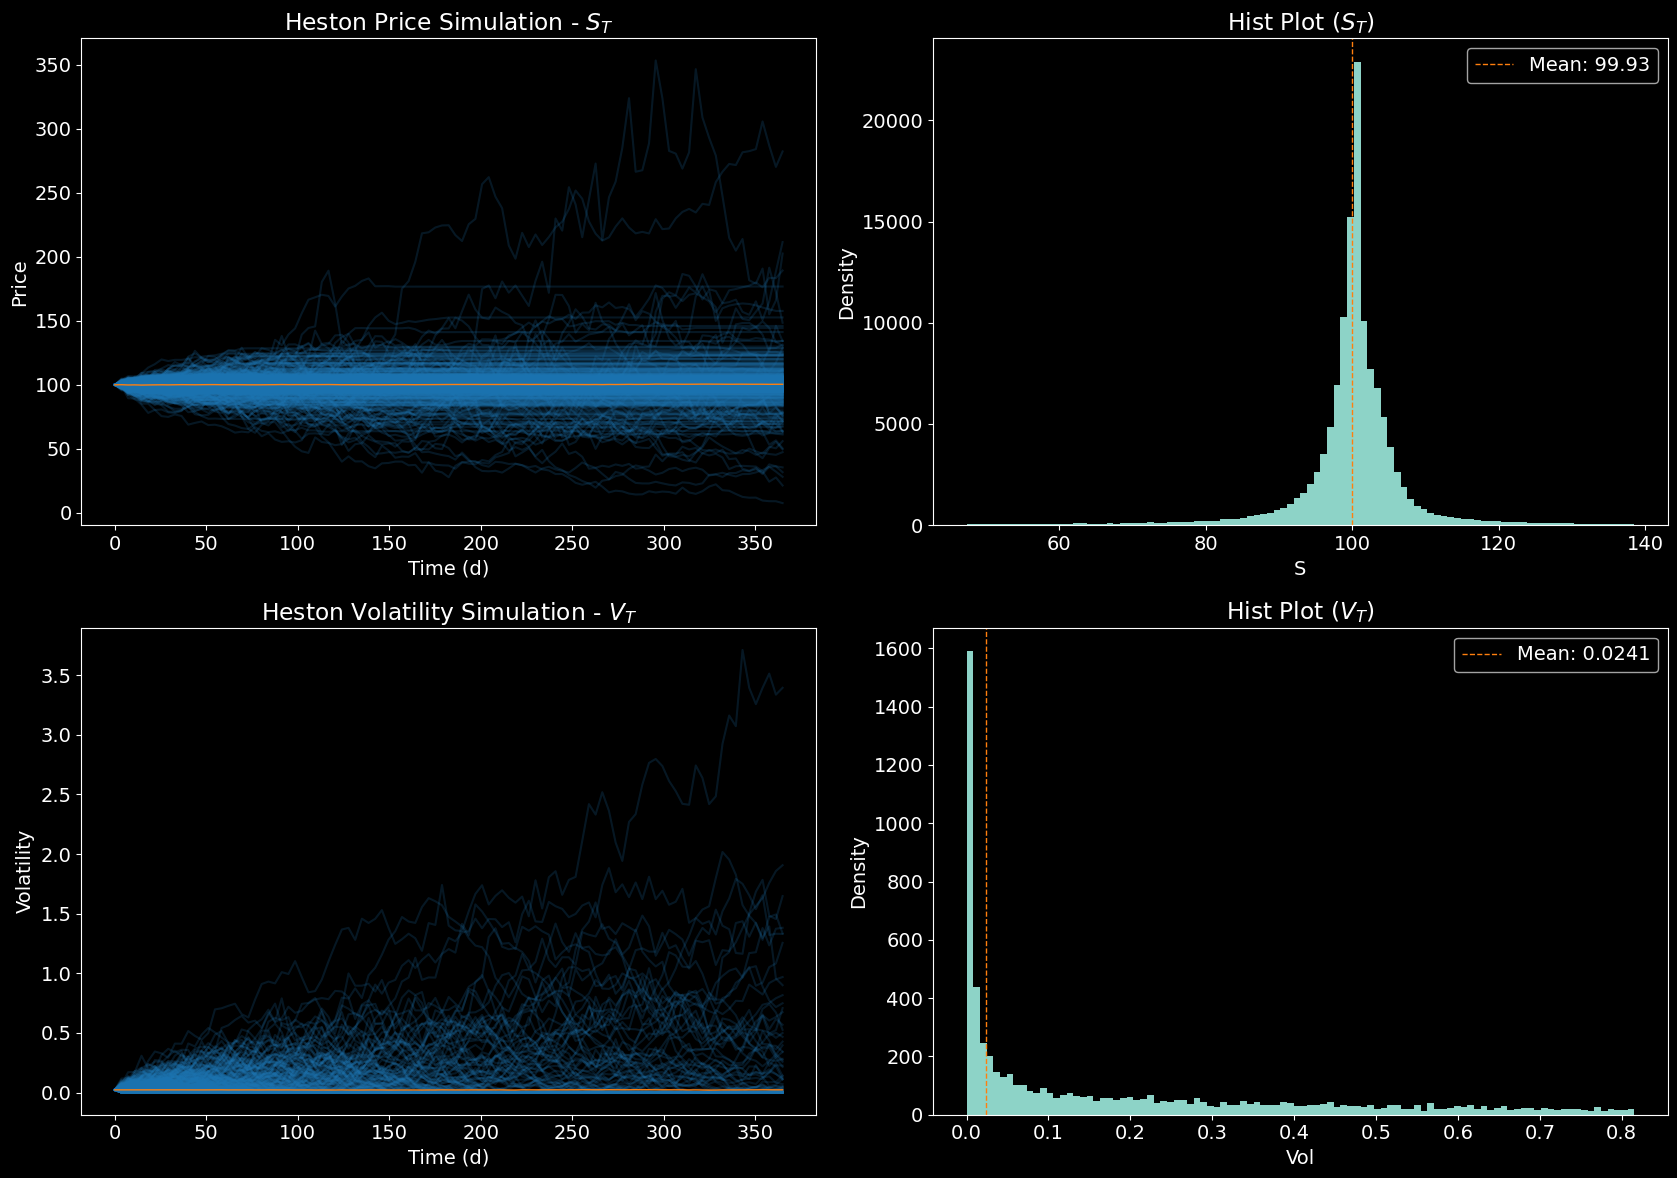

"N Paths: 131,072",Analytical,Empirical,95% CI,Difference
Moments,,,,
E[v_T],0.023847,0.024126,0.000752,-0.000280
E[v_T^2],0.030383,0.030162,0.001726,0.000221
Std[v_T],0.172668,0.171988,0.004797,0.000679
E[v_T^3],0.062238,0.056741,0.005623,0.005498
E[v_T^4],0.161257,0.137536,0.022012,0.023721


In [47]:
S0      = 100  # initial stock price 
r       = 0.00
q       = 0.00  # risk-free rate and dividend yield
v0      = 0.0228  # initial variance
theta   = 0.0363  # long-term mean variance
kappa   = 0.0807  # rate of mean reversion
sigma   = 1.1760  # volatility of variance
rho     = -0.3021   # correlation between stock and variance
N_paths = 100_000  ;    N_paths = int(2 ** np.ceil(np.log2(N_paths)))   # number of paths
T_steps = 100  # time horizon
T       = 1  # time horizon
dt      = 1/T_steps  # time step

print(f'Time step: {dt:.4f}, Time Horizon: {T} years with {int(2 ** np.ceil(np.log2(N_paths)))} paths and {T_steps} steps')
m1_vol_An, m2_vol_An, m3_vol_An, m4_vol_An, Var_vol_An = moments_CIR(kappa=kappa, theta=theta, sigma=sigma, v0=v0, T=T)


S_T_array_QE, v_T_array_QE = QESim(S0=S0, V0=v0, rho=rho, theta=theta, sigma=sigma, kappa=kappa, r=r, q=q, dt=dt,
                     T_steps=T_steps, N_paths=N_paths, Martingale_Correction=0)

# Test for if the moments of the vol mattch the theoretical values
m1_vol_Em   = v_T_array_QE[:,-1].mean()
m1_vol_SE   = v_T_array_QE[:,-1].reshape(128,-1).mean(axis=1).std() / sqrt(128)

m2_vol_Em   = ((v_T_array_QE[:,-1])**2).mean()
m2_vol_SE   = ((v_T_array_QE[:,-1])**2).reshape(128,-1).mean(axis=1).std() / sqrt(128)

Std_vol_Em  = v_T_array_QE[:,-1].std()
Std_vol_SE  = v_T_array_QE[:,-1].reshape(128,-1).std(axis=1).std() / sqrt(128)
Std_vol_An = np.sqrt(Var_vol_An)

m3_vol_Em   = ((v_T_array_QE[:,-1])**3).mean()
m3_vol_SE   = ((v_T_array_QE[:,-1])**3).reshape(128,-1).mean(axis=1).std() / sqrt(128)

m4_vol_Em   = ((v_T_array_QE[:,-1])**4).mean()
m4_vol_SE   = ((v_T_array_QE[:,-1])**4).reshape(128,-1).mean(axis=1).std() / sqrt(128)

# Creating the DataFrame
data = {
    'Analytical'    : [m1_vol_An, m2_vol_An, Std_vol_An, m3_vol_An, m4_vol_An],
    'Empirical'     : [m1_vol_Em, m2_vol_Em, Std_vol_Em, m3_vol_Em, m4_vol_Em],
    '95% CI'        : [1.96 * m1_vol_SE, 1.96 * m2_vol_SE, 1.96 * Std_vol_SE, 1.96 * m3_vol_SE, 1.96 * m4_vol_SE],
    'Difference'    : [m1_vol_An - m1_vol_Em, m2_vol_An - m2_vol_Em, Std_vol_An - Std_vol_Em, m3_vol_An - m3_vol_Em, m4_vol_An - m4_vol_Em],
}
index = ['E[v_T]', 'E[v_T^2]', 'Std[v_T]', 'E[v_T^3]', 'E[v_T^4]']
Moments_QE_df = pd.DataFrame(data, index=index)
Moments_QE_df.index.name = 'Moments'
Moments_QE_df.columns.name = f'N Paths: {N_paths:,}'


# visualize a_price and vol
bins = 100
fig, axs = plt.subplots(2, 2, figsize=(17, 12), tight_layout=True)
df_S = pd.DataFrame(S_T_array_QE[:1000]).T.set_index(np.linspace(0, T*365, T_steps+1))
df_S.plot(legend=False, color='tab:blue', alpha=0.2, ax=axs[0,0])
df_S.mean(axis=1).plot(ax=axs[0,0], color='tab:orange', alpha=1, linewidth=1)
axs[0,0].set(xlabel='Time (d)', ylabel='Price', title=r'Heston Price Simulation - $S_T$')

df_vol = pd.DataFrame(v_T_array_QE[:1000]).T.set_index(np.linspace(0, T*365, T_steps+1))
df_vol.plot(legend=False, color='tab:blue', alpha=0.2, ax=axs[1,0])
df_vol.mean(axis=1).plot(ax=axs[1,0], color='tab:orange', alpha=1, linewidth=1)
axs[1,0].set(xlabel='Time (d)', ylabel='Volatility', title=r'Heston Volatility Simulation - $V_T$')

# get the a_price which are within the 99 quantiles
_S_T_array_QE   = S_T_array_QE[(S_T_array_QE[:,-1] < np.quantile(S_T_array_QE[:,-1], 0.99)) & (S_T_array_QE[:,-1] > np.quantile(S_T_array_QE[:,-1], 0.01))]
_v_T_array_QE   = v_T_array_QE[(v_T_array_QE[:,-1] < np.quantile(v_T_array_QE[:,-1], 0.99)) & (v_T_array_QE[:,-1] > np.quantile(v_T_array_QE[:,-1], 0.01))]
axs[0,1].hist(_S_T_array_QE[:,-1], bins=bins)  
axs[0,1].axvline(S_T_array_QE[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=f'Mean: {S_T_array_QE[:,-1].mean():.2f}')
axs[0,1].set(xlabel='S', ylabel='Density', title=r'Hist Plot ($S_T$)')
axs[0,1].legend()
axs[1,1].hist(_v_T_array_QE[:,-1], bins=bins) 
axs[1,1].axvline(v_T_array_QE[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=f'Mean: {v_T_array_QE[:,-1].mean():.4f}')
axs[1,1].set(xlabel='Vol', ylabel='Density', title=r'Hist Plot ($V_T$)')
axs[1,1].legend()
plt.show()

Moments_QE_df.to_csv('Moments: QE Heston.csv', float_format='%.6f')
Moments_QE_df

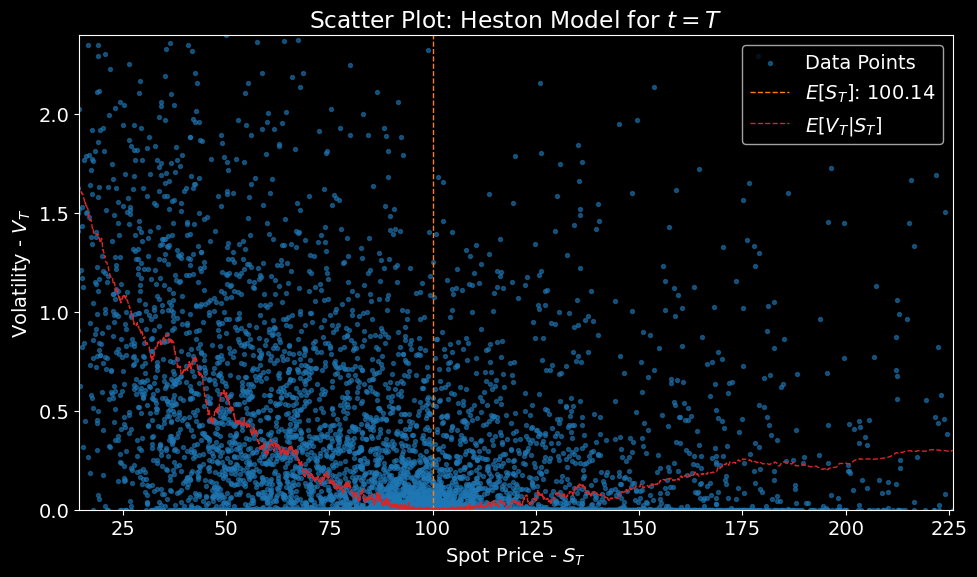

In [19]:
x_left_lim, x_right_lim = np.quantile(S_T_array_QE[:,-1], 0.001), np.quantile(S_T_array_QE[:,-1], 0.999)
y_upper_lim, y_lower_lim = np.quantile(v_T_array_QE[:,-1], 0.999), np.quantile(v_T_array_QE[:,-1], 0.001)   
unique_S_T = np.unique(S_T_array_QE[:, -1])

knn = KNeighborsRegressor(n_neighbors=200, n_jobs=-1)
knn.fit(S_T_array_QE[:, [-1]], v_T_array_QE[:,-1])
vol_pred = knn.predict(unique_S_T.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.scatter(S_T_array_QE[:100_000,-1], v_T_array_QE[:100_000,-1], alpha=0.6, color='tab:blue', label='Data Points', s=8)
plt.axvline(S_T_array_QE[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=r'$E[S_T]$: '+f'{S_T_array_QE[:,-1].mean():.2f}')
plt.plot(unique_S_T, vol_pred, label=r'$E[V_T|S_T]$', linestyle='dashed', linewidth=1, color='tab:red')
plt.xlim(x_left_lim, x_right_lim)
plt.ylim(y_lower_lim, y_upper_lim)
plt.xlabel(r'Spot Price - $S_T$')
plt.ylabel(r'Volatility - $V_T$')
plt.title(r'Scatter Plot: Heston Model for $t=T$')
plt.legend() ; plt.tight_layout() 
plt.show()

# Simulate the Heston model with Euler-Maruyama method
The Euler-Maruyama method is used to simulate the Heston Stochastic Volatility Model. The model equations are:

\begin{align*}
  \tilde{V}_t &= V_{t-1} + \kappa (\theta - V_{t-1}) \Delta t + \sigma \sqrt{V_{t-1}} dW^S_t \\
  V_t &= \max \left\{ \tilde{V}[t, :], 0 \right\} \\
  X_t &= X_{t-1} + \left(r - \frac{1}{2}V_{t-1}\right) \Delta t + \sqrt{V_{t-1}} dW^v_t \\
\end{align*}

Where:
$$
dW^S_t dW^v_t = \rho dt
$$


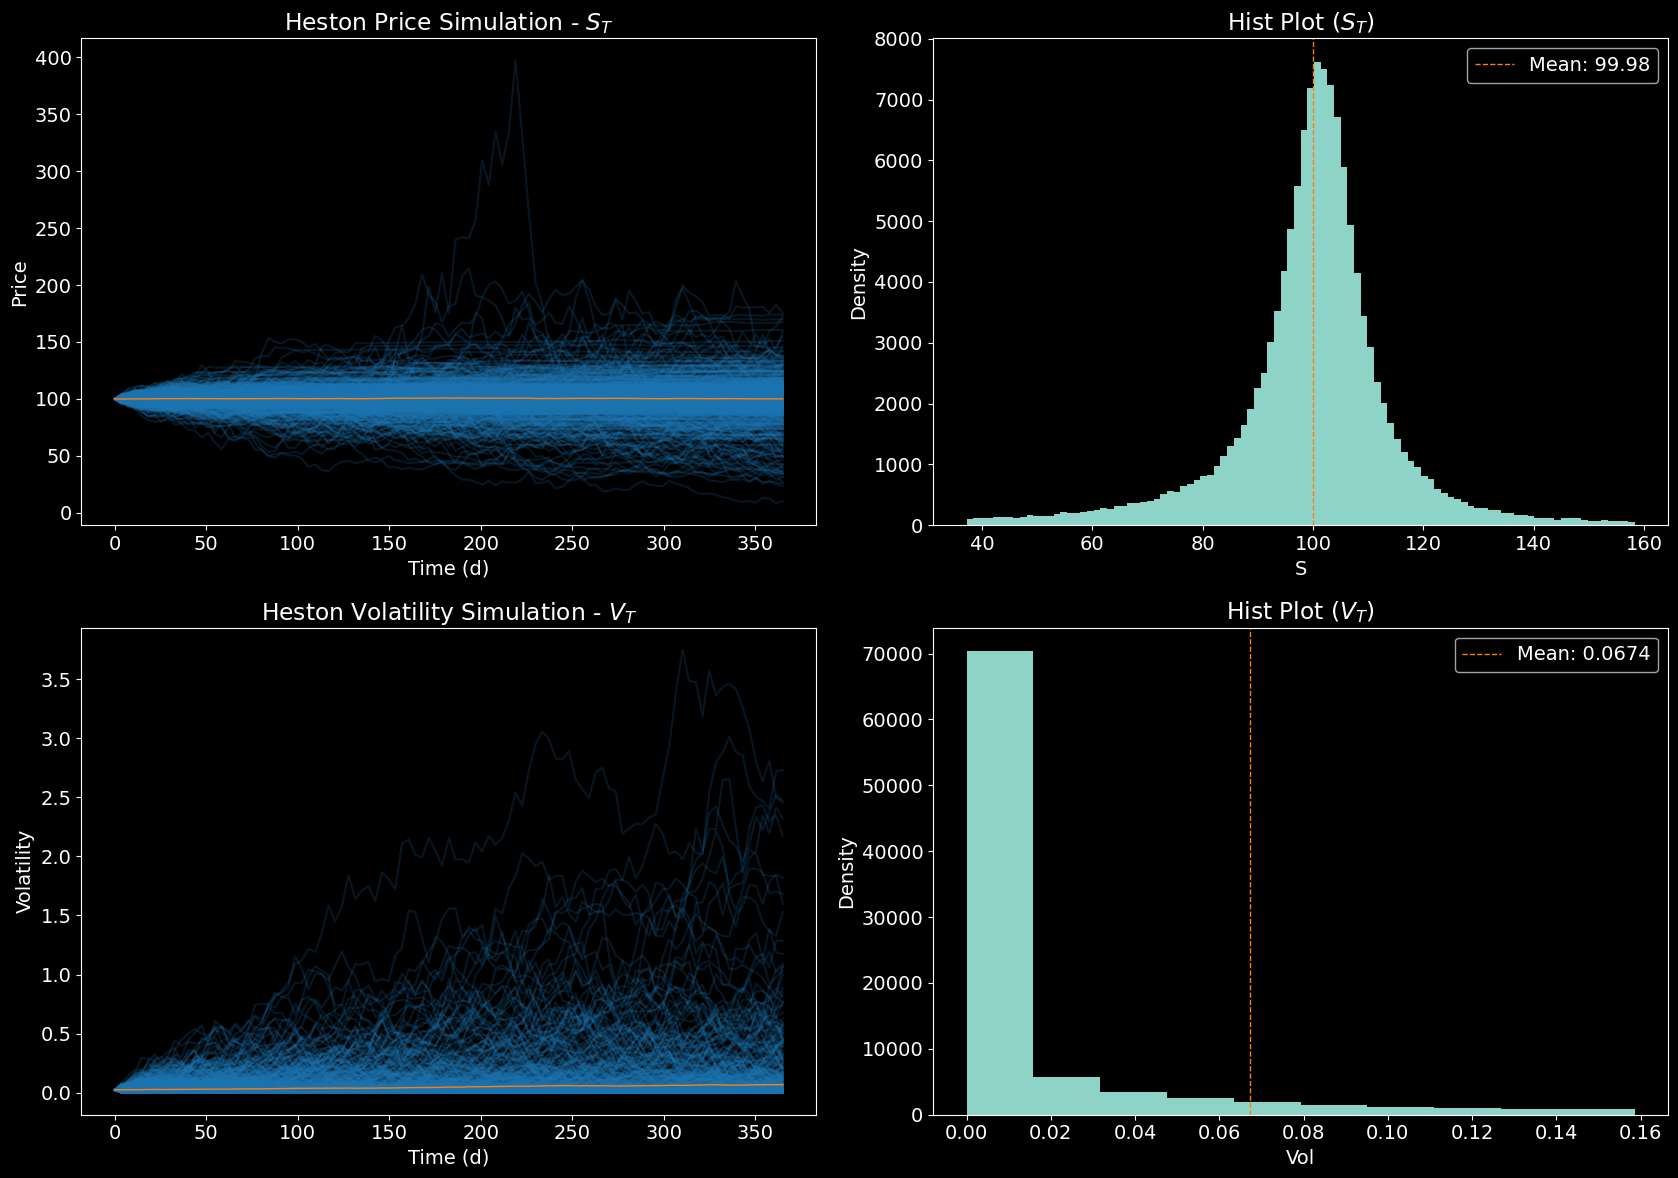

"N Paths: 131,072",Analytical,Empirical,95% CI,Difference
Moments,,,,
E[v_T],0.023847,0.067368,0.001307,-0.043521
E[v_T^2],0.030383,0.059333,0.002712,-0.028950
Std[v_T],0.172668,0.234082,0.005283,-0.061414
E[v_T^3],0.062238,0.095408,0.009163,-0.033169
E[v_T^4],0.161257,0.217230,0.042365,-0.055973


In [52]:
def sim_heston_simple(S0, V0, rho, theta, sigma, kappa, r, q, dt, T_steps, N_paths):
    # Pre-allocate arrays for stock prices and variances
    X_paths = np.zeros((T_steps + 1, N_paths))
    V_paths = np.zeros((T_steps + 1, N_paths))

    # Initial values
    X_paths[0, :] = log(S0)
    V_paths[0, :] = V0

    # Generate random numbers for the Brownian motions
    Z1 = np.random.normal(size=(T_steps, N_paths))
    Z2 = np.random.normal(size=(T_steps, N_paths))
    W1 = Z1
    W2 = rho * Z1 + np.sqrt(1 - rho ** 2) * Z2

    for t in range(1, T_steps + 1):
        # Ensure non-negativity of variance
        V_paths[t, :] = np.maximum(V_paths[t - 1, :] + kappa * (theta - V_paths[t - 1, :]) * dt + sigma * np.sqrt(V_paths[t - 1, :] * dt) * W2[t - 1, :], 0)
        
        # Calculate stock prices
        X_paths[t, :] = X_paths[t - 1, :] + ((r - q - 0.5 * V_paths[t - 1, :]) * dt + np.sqrt(V_paths[t - 1, :] * dt) * W1[t - 1, :])

    return exp(X_paths).T, V_paths.T

S_T_array_EM, v_T_array_EM = sim_heston_simple(S0=S0, V0=v0, rho=rho, theta=theta, sigma=sigma, kappa=kappa, r=r, q=q, dt=dt, T_steps=T_steps, N_paths=N_paths)

m1_vol_An, m2_vol_An, m3_vol_An, m4_vol_An, Var_vol_An = moments_CIR(kappa=kappa, theta=theta, sigma=sigma, v0=v0, T=T)

# Test for if the moments of the vol mattch the theoretical values
m1_vol_Em   = v_T_array_EM[:,-1].mean()
m1_vol_SE   = v_T_array_EM[:,-1].reshape(128,-1).mean(axis=1).std() / sqrt(128)

m2_vol_Em   = ((v_T_array_EM[:,-1])**2).mean()
m2_vol_SE   = ((v_T_array_EM[:,-1])**2).reshape(128,-1).mean(axis=1).std() / sqrt(128)

Std_vol_Em  = v_T_array_EM[:,-1].std()
Std_vol_SE  = v_T_array_EM[:,-1].reshape(128,-1).std(axis=1).std() / sqrt(128)

m3_vol_Em   = ((v_T_array_EM[:,-1])**3).mean()
m3_vol_SE   = ((v_T_array_EM[:,-1])**3).reshape(128,-1).mean(axis=1).std() / sqrt(128)

m4_vol_Em   = ((v_T_array_EM[:,-1])**4).mean()
m4_vol_SE   = ((v_T_array_EM[:,-1])**4).reshape(128,-1).mean(axis=1).std() / sqrt(128)

# Creating the DataFrame
data = {
    'Analytical': [m1_vol_An, m2_vol_An, Std_vol_An, m3_vol_An, m4_vol_An],
    'Empirical': [m1_vol_Em, m2_vol_Em, Std_vol_Em, m3_vol_Em, m4_vol_Em],
    '95% CI': [1.96 * m1_vol_SE, 1.96 * m2_vol_SE, 1.96 * Std_vol_SE, 1.96 * m3_vol_SE, 1.96 * m4_vol_SE],
    'Difference': [m1_vol_An - m1_vol_Em, m2_vol_An - m2_vol_Em, Std_vol_An - Std_vol_Em, m3_vol_An - m3_vol_Em, m4_vol_An - m4_vol_Em],
}
Moments_simple_df = pd.DataFrame(data, index=index)
Moments_simple_df.columns.name = f'N Paths: {N_paths:,}'
Moments_simple_df.index.name = 'Moments'


# visualize a_price and vol
bins = 100
fig, axs = plt.subplots(2, 2, figsize=(17, 12), tight_layout=True)
df_S = pd.DataFrame(S_T_array_EM[:1000]).T.set_index(np.linspace(0, T*365, T_steps+1))
df_S.plot(legend=False, color='tab:blue', alpha=0.2, ax=axs[0,0])
df_S.mean(axis=1).plot(ax=axs[0,0], color='tab:orange', alpha=1, linewidth=1)
axs[0,0].set(xlabel='Time (d)', ylabel='Price', title=r'Heston Price Simulation - $S_T$')

df_vol = pd.DataFrame(v_T_array_EM[:1000]).T.set_index(np.linspace(0, T*365, T_steps+1))
df_vol.plot(legend=False, color='tab:blue', alpha=0.2, ax=axs[1,0])
df_vol.mean(axis=1).plot(ax=axs[1,0], color='tab:orange', alpha=1, linewidth=1)
axs[1,0].set(xlabel='Time (d)', ylabel='Volatility', title=r'Heston Volatility Simulation - $V_T$')

# get the a_price which are within the 99 quantiles
_a_price = S_T_array_EM[(S_T_array_EM[:,-1] < np.quantile(S_T_array_EM[:,-1], 0.99)) & (S_T_array_EM[:,-1] > np.quantile(S_T_array_EM[:,-1], 0.01))]
_vol     = v_T_array_EM[(v_T_array_EM[:,-1] < np.quantile(v_T_array_EM[:,-1], 0.90)) & (v_T_array_EM[:,-1] > np.quantile(v_T_array_EM[:,-1], 0.01))]
axs[0,1].hist(_a_price[:,-1], bins=bins)  
axs[0,1].axvline(S_T_array_EM[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=f'Mean: {S_T_array_EM[:,-1].mean():.2f}')
axs[0,1].set(xlabel='S', ylabel='Density', title=r'Hist Plot ($S_T$)')
axs[0,1].legend()
axs[1,1].hist(_vol[:,-1], bins=int(bins/10))
axs[1,1].axvline(v_T_array_EM[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=f'Mean: {v_T_array_EM[:,-1].mean():.4f}')
axs[1,1].set(xlabel='Vol', ylabel='Density', title=r'Hist Plot ($V_T$)')
axs[1,1].legend()
plt.show()

Moments_simple_df.to_csv('Moments: Simple Heston.csv', float_format='%.6f')
Moments_simple_df

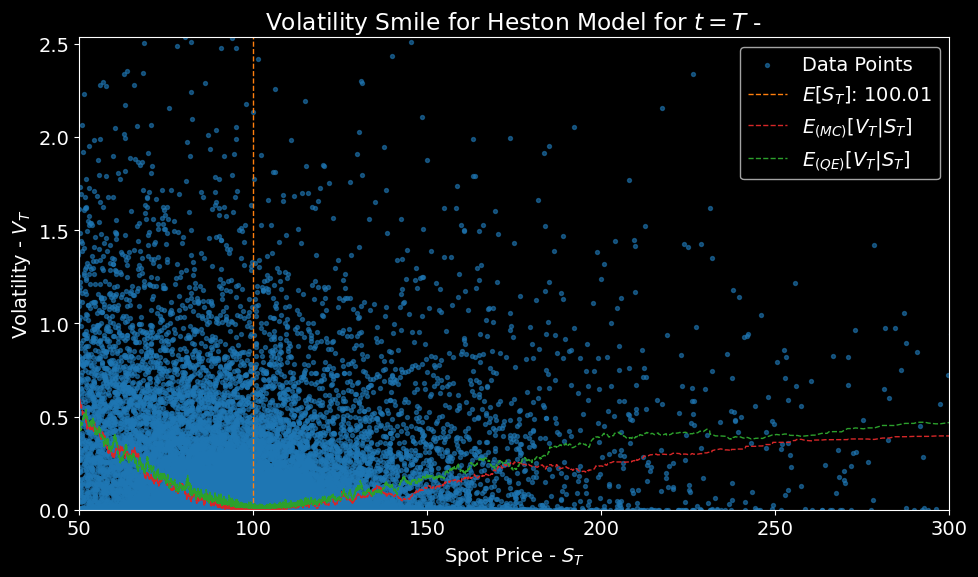

In [21]:
x_left_lim, x_right_lim = np.quantile(S_T_array_EM[:,-1], 0.001), np.quantile(S_T_array_EM[:,-1], 0.999)
y_upper_lim, y_lower_lim = np.quantile(v_T_array_EM[:,-1], 0.999), np.quantile(v_T_array_EM[:,-1], 0.001)   
unique_S_T = np.unique(S_T_array_EM[:, -1])

knn2 = KNeighborsRegressor(n_neighbors=200, n_jobs=-1)
knn2.fit(S_T_array_EM[:, -1].reshape(-1, 1), v_T_array_EM[:,-1])
vol_pred  = knn.predict(unique_S_T.reshape(-1, 1))
vol_pred2 = knn2.predict(unique_S_T.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.scatter(S_T_array_EM[:100_000,-1], v_T_array_EM[:100_000,-1], alpha=0.6, color='tab:blue', label='Data Points', s=8)
plt.axvline(S_T_array_EM[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=r'$E[S_T]$: '+f'{S_T_array_EM[:,-1].mean():.2f}')
plt.plot(unique_S_T, vol_pred, label=r'$E_{(MC)}[V_T|S_T]$', linestyle='dashed', linewidth=1, color='tab:red')
plt.plot(unique_S_T, vol_pred2, label=r'$E_{(QE)}[V_T|S_T]$ ', linestyle='dashed', linewidth=1, color='tab:green')
plt.xlim(50, 300)
plt.ylim(y_lower_lim, y_upper_lim)
plt.xlabel(r'Spot Price - $S_T$')
plt.ylabel(r'Volatility - $V_T$')
plt.title(r'Volatility Smile for Heston Model for $t=T$ - ')
plt.legend() ; plt.tight_layout() 
plt.show()

-------------------------------------------------------
# Plot Implied volatility surface of Heston model

In [22]:
from scipy.integrate import quad
from functools import partial

def Heston_FFT(S0, K, T, r, kappa, theta, sigma, v0, rho, opt_type):

    def Q1(k, cf, right_lim):
        """
        P(X<k) - Probability to be in the money under the stock numeraire.
        cf: characteristic function
        right_lim: right limit of integration
        """

        def integrand(u):
            return np.real((np.exp(-u * k * 1j) / (u * 1j)) * cf(u - 1j) / cf(-1.0000000000001j))

        return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit=2000)[0]


    def Q2(k, cf, right_lim):
        """
        P(X<k) - Probability to be in the money under the money market numeraire
        cf: characteristic function
        right_lim: right limit of integration
        """

        def integrand(u):
            return np.real(np.exp(-u * k * 1j) / (u * 1j) * cf(u))

        return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit=2000)[0]

    def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
        """
        Heston characteristic function as proposed by Schoutens (2004)
        """
        xi = kappa - sigma * rho * u * 1j
        d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j * u))
        g1 = (xi + d) / (xi - d)
        g2 = 1 / g1
        cf = np.exp(
            1j * u * mu * t
            + (kappa * theta) / (sigma**2) * ((xi - d) * t - 2 * np.log((1 - g2 * np.exp(-d * t)) / (1 - g2)))
            + (v0 / sigma**2) * (xi - d) * (1 - np.exp(-d * t)) / (1 - g2 * np.exp(-d * t))
        )
        return cf

    cf_H_b_good = partial(cf_Heston_good, t=T, v0=v0, mu=r, theta=theta, sigma=sigma, kappa=kappa, rho=rho)

    k = np.log(K / S0)  # log moneyness
    limit_max = 1000  # right limit in the integration
    call = S0 * Q1(k, cf_H_b_good, limit_max) - K * np.exp(-r * T) * Q2(k, cf_H_b_good, limit_max)

    return call if opt_type == 'c' else call + K * np.exp(-r * T) - S0

  0%|          | 0/100 [00:00<?, ?it/s]

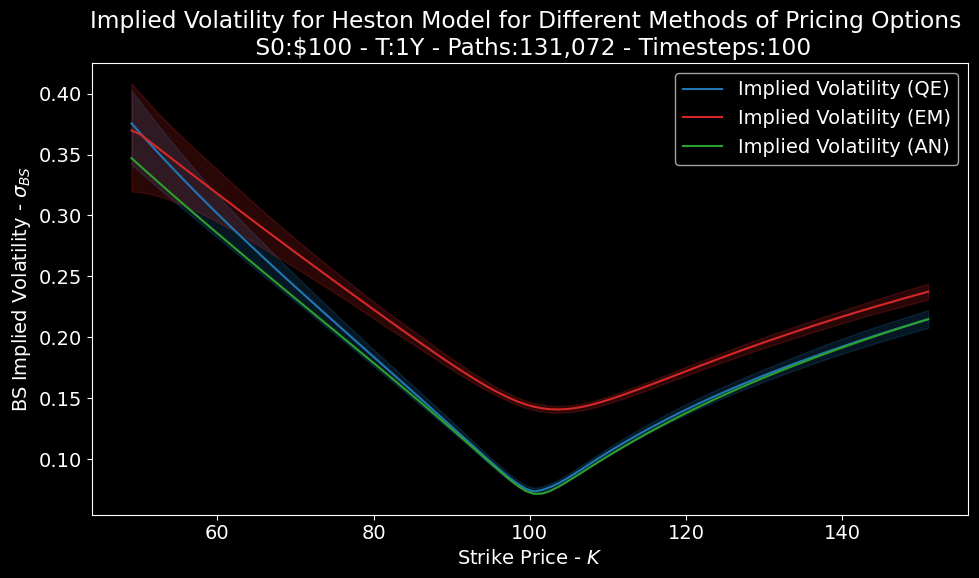

In [23]:
import py_vollib_vectorized

K_array = np.linspace(49, 151, 100)
def Bootstrap_IV(S_T_array):
    np.random.seed(42)
    n = 1_00
    idxs = np.random.choice(S_T_array.shape[0], (n, 30_000), replace=1)

    IV_B = []
    for idx in tqdm(idxs, leave=False):
        S_T = S_T_array[idx]
        _C0 = np.array([np.exp(-r * T) * np.maximum(S_T - K, 0).mean() for K in K_array])
        _ivs = py_vollib_vectorized.vectorized_implied_volatility(
                price=_C0, S=S0, K=K_array, t=T, r=r, flag='c', q=0.0, on_error='ignore', model='black_scholes_merton',return_as='numpy') 
        
        IV_B.append(_ivs)
    IV_B = np.array(IV_B)        

    IV_mean = IV_B.mean(axis=0)
    IV_5, IV_95 = np.percentile(IV_B, [5, 95], axis=0)
    IV_SE   = 1.96 * IV_B.std(axis=0) #/ np.sqrt(n)

    return IV_mean, IV_SE, IV_5, IV_95


IV_mean_EM, IV_SE_EM, IV_5_EM, IV_95_EM = Bootstrap_IV(S_T_array_EM[:,-1])
IV_mean_QE, IV_SE_QE, IV_5_QE, IV_95_QE = Bootstrap_IV(S_T_array_QE[:,-1])

C0_FFT = [Heston_FFT(S0=S0, K=K, T=T, r=r, kappa=kappa, theta=theta, rho=rho, sigma=sigma, v0=v0, opt_type='c') for K in K_array]
iv_array_FFT = py_vollib_vectorized.vectorized_implied_volatility(
    price=C0_FFT, S=S0, K=K_array, t=T, r=r, flag='c', q=q, on_error='ignore', model='black_scholes_merton',return_as='numpy')

C0_QE = np.array([np.exp(-r * T) * np.maximum(S_T_array_QE[:,-1] - K, 0).mean() for K in K_array])
iv_array_QE = py_vollib_vectorized.vectorized_implied_volatility(
    price=C0_QE, S=S0, K=K_array, t=T, r=r, flag='c', q=q, on_error='ignore', model='black_scholes_merton',return_as='numpy')

plt.figure(figsize=(10, 6))
plt.plot(K_array, IV_mean_QE, label='Implied Volatility (QE)', color='tab:blue')
# plt.plot(K_array, iv_array_QE, label='Implied Volatility (QE2)', color='blue')
# plt.fill_between(K_array, IV_mean_QE - IV_SE_QE, IV_mean_QE + IV_SE_QE, alpha=0.2, color='tab:blue')
plt.fill_between(K_array, IV_5_QE, IV_95_QE, alpha=0.2, color='tab:blue')

plt.plot(K_array, IV_mean_EM, label='Implied Volatility (EM)', color='tab:red')
# plt.fill_between(K_array, IV_mean_EM - IV_SE_EM, IV_mean_EM + IV_SE_EM, alpha=0.2, color='tab:red')
plt.fill_between(K_array, IV_5_EM, IV_95_EM, alpha=0.2, color='tab:red')

plt.plot(K_array, iv_array_FFT, label='Implied Volatility (AN)', color='tab:green')
plt.xlabel(r'Strike Price - $K$') ; plt.ylabel(r'BS Implied Volatility - $\sigma_{BS}$')
plt.title(f'Implied Volatility for Heston Model for Different Methods of Pricing Options \n S0:${S0} - T:{T}Y - Paths:{N_paths:,} - Timesteps:{T_steps:,}')
plt.legend() ; plt.tight_layout() ; plt.show()

In [24]:
# Assuming Moments_simple_df and Moments_QE_df are already defined
combined_df = pd.concat([Moments_simple_df.add_prefix('(EM)'), Moments_QE_df.add_prefix('(QE)')], axis=1)
combined_df.rename(columns={'(EM)Analytical': 'Analytical'}, inplace=True)
# Reorder columns
combined_df = combined_df[['Analytical', '(EM)Empirical', '(EM)95% CI', '(EM)Difference', '(QE)Empirical', '(QE)95% CI', '(QE)Difference']]
combined_df.index.name = 'Moments'
combined_df.columns.name = f'N: {N_paths:,}, T: {T_steps}'
combined_df

"N: 131,072, T: 100",Analytical,(EM)Empirical,(EM)95% CI,(EM)Difference,(QE)Empirical,(QE)95% CI,(QE)Difference
Moments,,,,,,,
E[v_T],0.023847,0.066126,0.001275,-0.042279,0.023535,0.000744,0.000311
E[v_T^2],0.030383,0.057819,0.002511,-0.027436,0.031153,0.002081,-0.000770
Std[v_T],0.172668,0.231185,0.005015,-0.058517,0.174925,0.005740,-0.002257
E[v_T^3],0.062238,0.094467,0.008335,-0.032228,0.065204,0.007875,-0.002966
E[v_T^4],0.161257,0.220824,0.035255,-0.059567,0.182260,0.034783,-0.021003


-------------------------------------------------------
# Difference in moments as a function of N_pants and T_steps

In [25]:
# print(stop)
def get_difference_in_moments(method, N_paths, T_steps):
    dt      = 1/T_steps 
    S_T_array, v_T_array = method(S0=S0, V0=v0, rho=rho, theta=theta, sigma=sigma, kappa=kappa, r=r, q=0, dt=dt, T_steps=T_steps, N_paths=N_paths)
    m1_vol_An, m2_vol_An, m3_vol_An, m4_vol_An, Var_vol_An = moments_CIR(kappa=kappa, theta=theta, sigma=sigma, v0=v0, T=T)
    Std_vol_An = np.sqrt(Var_vol_An)
    # Test for if the moments of the vol mattch the theoretical values
    m1_vol_Em   = v_T_array[:,-1].mean()
    m1_vol_SE   = v_T_array[:,-1].reshape(128,-1).mean(axis=1).std() / sqrt(128)

    m2_vol_Em   = ((v_T_array[:,-1])**2).mean()
    m2_vol_SE   = ((v_T_array[:,-1])**2).reshape(128,-1).mean(axis=1).std() / sqrt(128)

    Std_vol_Em  = v_T_array[:,-1].std()
    Std_vol_SE  = v_T_array[:,-1].reshape(128,-1).std(axis=1).std() / sqrt(128)

    m3_vol_Em   = ((v_T_array[:,-1])**3).mean()
    m3_vol_SE   = ((v_T_array[:,-1])**3).reshape(128,-1).mean(axis=1).std() / sqrt(128)

    m4_vol_Em   = ((v_T_array[:,-1])**4).mean()
    m4_vol_SE   = ((v_T_array[:,-1])**4).reshape(128,-1).mean(axis=1).std() / sqrt(128)

    return m1_vol_An - m1_vol_Em, m2_vol_An - m2_vol_Em, Std_vol_An - Std_vol_Em, m3_vol_An - m3_vol_Em, m4_vol_An - m4_vol_Em


-------------------------------------------------------
# Moments Analysis as a Function of the Number of Timesteps

In [26]:
import gc

# N_paths = 2**14 # 16384
N_paths = 2**17 # 131072
T_steps_array = [2, 4, 12, 52, 100, 365]

_diffs_QE_Timesteps = []
_diffs_EM_Timesteps = []

n_bootstrap_samples = 10
for t_steps in (T_steps_array):
    print(f'Running for {t_steps} steps ===========================', end='\n')
    _diffs_QE_Timesteps.append(
        np.array([ (get_difference_in_moments(QESim, N_paths, t_steps)) for _ in range(n_bootstrap_samples)]).T
    )
    _diffs_EM_Timesteps.append(
        np.array([ (get_difference_in_moments(sim_heston_simple, N_paths, t_steps)) for _ in range(n_bootstrap_samples)]).T
    )
    gc.collect()

_diffs_QE_Timesteps = np.array(_diffs_QE_Timesteps)
_diffs_EM_Timesteps = np.array(_diffs_EM_Timesteps)

Running for 2 steps ===========================


Running for 4 steps ===========================


Running for 12 steps ===========================


Running for 52 steps ===========================


Running for 100 steps ===========================


Running for 365 steps ===========================


Simulating Paths:  77%|███████▋  | 280/365 [00:03<00:00, 95.04it/s] /var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_45171/4177653482.py:45: RuntimeWarning: invalid value encountered in multiply
  S[t] = S[t - 1] + (r - q) * dt + K0_star + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t]


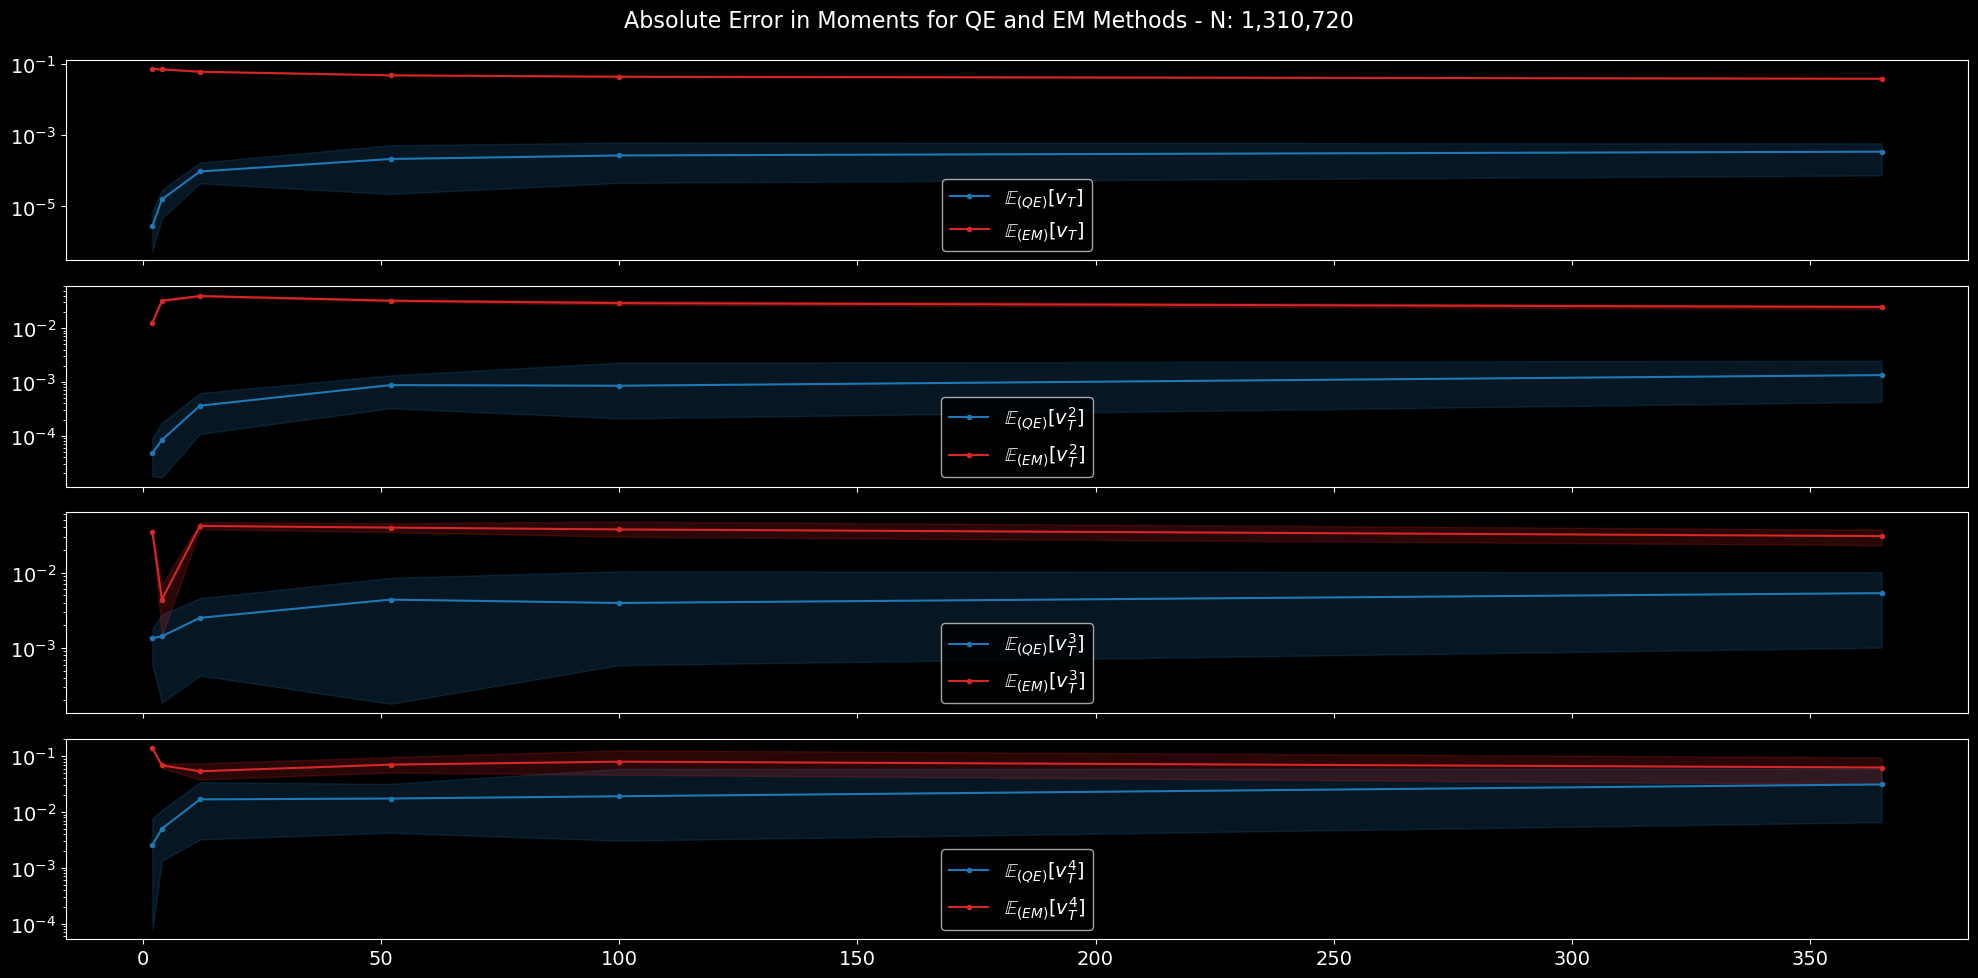

In [27]:
# diffs_QE_Timesteps = _diffs_QE_Timesteps            ; diffs_EM_Timesteps = _diffs_EM_Timesteps
diffs_QE_Timesteps = np.abs(_diffs_QE_Timesteps)    ; diffs_EM_Timesteps = np.abs(_diffs_EM_Timesteps)

Means_QE_Timesteps = diffs_QE_Timesteps.mean(axis=(2))
Q5_QE, Q95_QE = np.percentile(diffs_QE_Timesteps, [5, 95], axis=(2))

Means_EM_Timesteps = diffs_EM_Timesteps.mean(axis=(2))
Q5_EM, Q95_EM = np.percentile(diffs_EM_Timesteps, [5, 95], axis=(2))

# plot the differences in moments and their 95% CI
fig, axs = plt.subplots(4, figsize=(20, 10), tight_layout=True, sharex=True)
axs[0].plot(T_steps_array, Means_QE_Timesteps[:,0], label=r'$\mathbb{E}_{(QE)}[v_T]$', color='tab:blue', marker='.')
axs[0].fill_between(T_steps_array, Q5_QE[:,0], Q95_QE[:,0], alpha=0.2, color='tab:blue')
axs[0].plot(T_steps_array, Means_EM_Timesteps[:,0], label=r'$\mathbb{E}_{(EM)}[v_T]$', color='tab:red', marker='.')
axs[0].fill_between(T_steps_array, Q5_EM[:,0], Q95_EM[:,0], alpha=0.2, color='tab:red')

# E[v_T^2]
axs[1].plot(T_steps_array, Means_QE_Timesteps[:,1], label=r'$\mathbb{E}_{(QE)}[v_T^2]$', color='tab:blue', marker='.')
axs[1].fill_between(T_steps_array, Q5_QE[:,1], Q95_QE[:,1], alpha=0.2, color='tab:blue')
axs[1].plot(T_steps_array, Means_EM_Timesteps[:,1], label=r'$\mathbb{E}_{(EM)}[v_T^2]$', color='tab:red', marker='.')
axs[1].fill_between(T_steps_array, Q5_EM[:,1], Q95_EM[:,1], alpha=0.2, color='tab:red')

# E[v_T^3]
axs[2].plot(T_steps_array, Means_QE_Timesteps[:,3], label=r'$\mathbb{E}_{(QE)}[v_T^3]$', color='tab:blue', marker='.')
axs[2].fill_between(T_steps_array, Q5_QE[:,3], Q95_QE[:,3], alpha=0.2, color='tab:blue')
axs[2].plot(T_steps_array, Means_EM_Timesteps[:,3], label=r'$\mathbb{E}_{(EM)}[v_T^3]$', color='tab:red', marker='.')
axs[2].fill_between(T_steps_array, Q5_EM[:,3], Q95_EM[:,3], alpha=0.2, color='tab:red')

# E[v_T^4]
axs[3].plot(T_steps_array, Means_QE_Timesteps[:,4], label=r'$\mathbb{E}_{(QE)}[v_T^4]$', color='tab:blue', marker='.')
axs[3].fill_between(T_steps_array, Q5_QE[:,4], Q95_QE[:,4], alpha=0.2, color='tab:blue')
axs[3].plot(T_steps_array, Means_EM_Timesteps[:,4], label=r'$\mathbb{E}_{(EM)}[v_T^4]$', color='tab:red', marker='.')
axs[3].fill_between(T_steps_array, Q5_EM[:,4], Q95_EM[:,4], alpha=0.2, color='tab:red')

axs[0].legend(loc='lower center') ; axs[1].legend(loc='lower center') ; axs[2].legend(loc='lower center') ; axs[3].legend(loc='lower center')
fig.suptitle(f'Absolute Error in Moments for QE and EM Methods - N: {N_paths*n_bootstrap_samples:,}', fontsize=16)
axs[0].set_yscale('log') ; axs[1].set_yscale('log') ; axs[2].set_yscale('log') ; axs[3].set_yscale('log')
plt.show()

In [29]:
E_v_df_1 = pd.concat([
    pd.DataFrame(Means_QE_Timesteps[:,0], index=T_steps_array, columns=['E[v_T](QE)']),
    pd.DataFrame(Means_EM_Timesteps[:,0], index=T_steps_array, columns=['E[v_T](EM)']),
    pd.DataFrame(Means_QE_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^2](QE)']),
    pd.DataFrame(Means_EM_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^2](EM)']),
], axis=1)
E_v_df_1.index.name = 'T_steps'
E_v_df_1.columns.name = f'N: {N_paths*n_bootstrap_samples:,}'
E_v_df_1.to_csv('Table: Per Timesteps: E_v 1.csv', float_format='%.6f')
E_v_df_1

"N: 1,310,720",E[v_T](QE),E[v_T](EM),E[v_T^2](QE),E[v_T^2](EM)
T_steps,,,,
2,0.000003,0.070728,0.000003,0.070728
4,0.000016,0.069172,0.000016,0.069172
12,0.000095,0.059191,0.000095,0.059191
52,0.000213,0.046980,0.000213,0.046980
100,0.000268,0.042959,0.000268,0.042959
365,0.000341,0.037678,0.000341,0.037678


In [35]:
E_v_df_2 = pd.concat([
    pd.DataFrame(Means_QE_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^3](QE)']),
    pd.DataFrame(Means_EM_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^3](EM)']),
    pd.DataFrame(Means_QE_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^4](QE)']),
    pd.DataFrame(Means_EM_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^4](EM)']),
], axis=1)
E_v_df_2.index.name = 'T_steps'
E_v_df_2.columns.name = f'N: {N_paths*n_bootstrap_samples:,}'
E_v_df_2.to_csv('Table: Per Timesteps: E_v 2.csv', float_format='%.6f')
E_v_df_2

"N: 1,310,720",E[v_T^3](QE),E[v_T^3](EM),E[v_T^4](QE),E[v_T^4](EM)
T_steps,,,,
2,0.000003,0.070728,0.000003,0.070728
4,0.000016,0.069172,0.000016,0.069172
12,0.000095,0.059191,0.000095,0.059191
52,0.000213,0.046980,0.000213,0.046980
100,0.000268,0.042959,0.000268,0.042959
365,0.000341,0.037678,0.000341,0.037678


In [36]:
E_v_df_2 = pd.concat([
    pd.DataFrame(Means_QE_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^3](QE)']),
    pd.DataFrame(Means_EM_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^3](EM)']),
    pd.DataFrame(Means_QE_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^4](QE)']),
    pd.DataFrame(Means_EM_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^4](EM)']),
], axis=1)
E_v_df_2.index.name = 'T_steps'
E_v_df_2.columns.name = f'N: {N_paths*n_bootstrap_samples:,}'
E_v_df_2.to_csv('Table: Per Timesteps: E_v 2.csv', float_format='%.6f')
E_v_df_2

"N: 1,310,720",E[v_T^3](QE),E[v_T^3](EM),E[v_T^4](QE),E[v_T^4](EM)
T_steps,,,,
2,0.000003,0.070728,0.000003,0.070728
4,0.000016,0.069172,0.000016,0.069172
12,0.000095,0.059191,0.000095,0.059191
52,0.000213,0.046980,0.000213,0.046980
100,0.000268,0.042959,0.000268,0.042959
365,0.000341,0.037678,0.000341,0.037678


-------------------------------------------------------
# Moments Analysis as a Function of the Number of Paths

In [37]:
import gc

N_paths_array = 2**np.arange(10, 19)
t_steps = 100

_diffs_QE_Paths = []
_diffs_EM_Paths = []

n_bootstrap_samples = 10
for n_paths in (N_paths_array):
    print(f'Running for {n_paths} paths ===========================', end='\r')
    _diffs_QE_Paths.append(
        np.array([ (get_difference_in_moments(QESim, n_paths, t_steps)) for _ in range(n_bootstrap_samples)]).T
        # get_difference_in_moments(QESim, N_paths, t_steps)
    )
    _diffs_EM_Paths.append(
        np.array([ (get_difference_in_moments(sim_heston_simple, n_paths, t_steps)) for _ in range(n_bootstrap_samples)]).T
        # get_difference_in_moments(sim_heston_simple ,N_paths, t_steps)
    )
    gc.collect()

_diffs_QE_Paths = np.array(_diffs_QE_Paths)
_diffs_EM_Paths = np.array(_diffs_EM_Paths)

Simulating Paths:  46%|████▌     | 46/100 [00:00<00:00, 222.57it/s]/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_45171/4177653482.py:45: RuntimeWarning: invalid value encountered in multiply
  S[t] = S[t - 1] + (r - q) * dt + K0_star + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t]


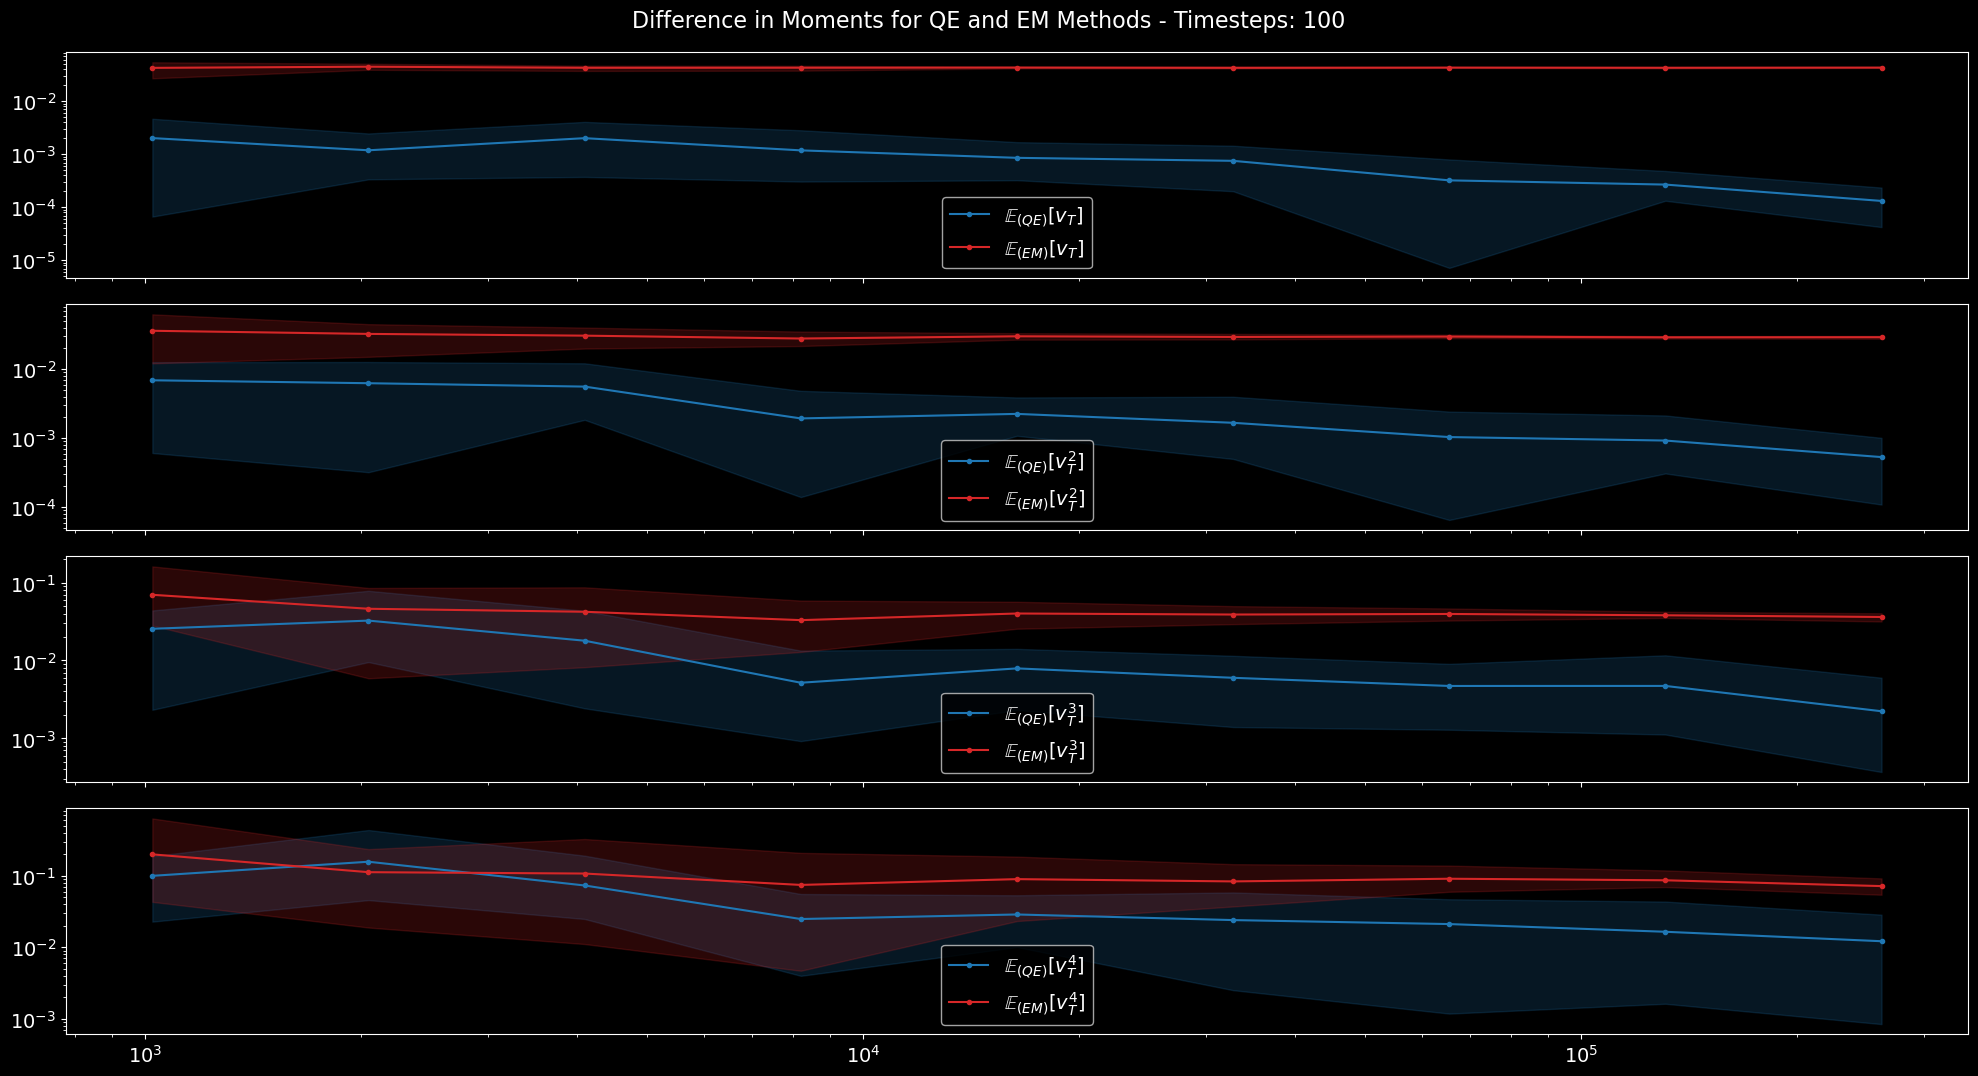

In [38]:
# plot diffs_QE
diffs_QE_Paths = _diffs_QE_Paths            ; diffs_EM_Paths = _diffs_EM_Paths
diffs_QE_Paths = np.abs(_diffs_QE_Paths)    ; diffs_EM_Paths = np.abs(_diffs_EM_Paths)

Means_QE_Paths = diffs_QE_Paths.mean(axis=(2))
Q5_QE, Q95_QE = np.percentile(diffs_QE_Paths, [5, 95], axis=(2))

Means_EM_Paths = diffs_EM_Paths.mean(axis=(2))
Q5_EM, Q95_EM = np.percentile(diffs_EM_Paths, [5, 95], axis=(2))

# plot the differences in moments and their 95% CI
fig, axs = plt.subplots(4, figsize=(20, 11), tight_layout=True, sharex=True)
axs[0].plot(N_paths_array, Means_QE_Paths[:,0], label=r'$\mathbb{E}_{(QE)}[v_T]$', color='tab:blue', marker='.')
axs[0].fill_between(N_paths_array, Q5_QE[:,0], Q95_QE[:,0], alpha=0.2, color='tab:blue')
axs[0].plot(N_paths_array, Means_EM_Paths[:,0], label=r'$\mathbb{E}_{(EM)}[v_T]$', color='tab:red', marker='.')
axs[0].fill_between(N_paths_array, Q5_EM[:,0], Q95_EM[:,0], alpha=0.2, color='tab:red')

# E[v_T^2]
axs[1].plot(N_paths_array, Means_QE_Paths[:,1], label=r'$\mathbb{E}_{(QE)}[v_T^2]$', color='tab:blue', marker='.')
axs[1].fill_between(N_paths_array, Q5_QE[:,1], Q95_QE[:,1], alpha=0.2, color='tab:blue')
axs[1].plot(N_paths_array, Means_EM_Paths[:,1], label=r'$\mathbb{E}_{(EM)}[v_T^2]$', color='tab:red', marker='.')
axs[1].fill_between(N_paths_array, Q5_EM[:,1], Q95_EM[:,1], alpha=0.2, color='tab:red')

# E[v_T^3]
axs[2].plot(N_paths_array, Means_QE_Paths[:,3], label=r'$\mathbb{E}_{(QE)}[v_T^3]$', color='tab:blue', marker='.')
axs[2].fill_between(N_paths_array, Q5_QE[:,3], Q95_QE[:,3], alpha=0.2, color='tab:blue')
axs[2].plot(N_paths_array, Means_EM_Paths[:,3], label=r'$\mathbb{E}_{(EM)}[v_T^3]$', color='tab:red', marker='.')
axs[2].fill_between(N_paths_array, Q5_EM[:,3], Q95_EM[:,3], alpha=0.2, color='tab:red')

# E[v_T^4]
axs[3].plot(N_paths_array, Means_QE_Paths[:,4], label=r'$\mathbb{E}_{(QE)}[v_T^4]$', color='tab:blue', marker='.')
axs[3].fill_between(N_paths_array, Q5_QE[:,4], Q95_QE[:,4], alpha=0.2, color='tab:blue')
axs[3].plot(N_paths_array, Means_EM_Paths[:,4], label=r'$\mathbb{E}_{(EM)}[v_T^4]$', color='tab:red', marker='.')
axs[3].fill_between(N_paths_array, Q5_EM[:,4], Q95_EM[:,4], alpha=0.2, color='tab:red')

axs[0].legend(loc='lower center') ; axs[1].legend(loc='lower center') ; axs[2].legend(loc='lower center') ; axs[3].legend(loc='lower center')
fig.suptitle(f'Difference in Moments for QE and EM Methods - Timesteps: {t_steps:,}', fontsize=16)
axs[0].set_yscale('log') ; axs[1].set_yscale('log') ; axs[2].set_yscale('log') ; axs[3].set_yscale('log')
plt.xscale('log')
plt.show()

In [39]:
E_v_df_11 = pd.concat([
    pd.DataFrame(Means_QE_Paths[:,0], index=N_paths_array, columns=['E[v_T](QE)']),
    pd.DataFrame(Means_EM_Paths[:,0], index=N_paths_array, columns=['E[v_T](EM)']),
    pd.DataFrame(Means_QE_Paths[:,1], index=N_paths_array, columns=['E[v_T^2](QE)']),
    pd.DataFrame(Means_EM_Paths[:,1], index=N_paths_array, columns=['E[v_T^2](EM)']),
], axis=1)
E_v_df_11.index.name = 'N paths'
E_v_df_11.columns.name = f'T steps: {t_steps:,}'
E_v_df_11.to_csv('Table: Per Paths: E_v 1.csv', float_format='%.6f')
E_v_df_11

T steps: 100,E[v_T](QE),E[v_T](EM),E[v_T^2](QE),E[v_T^2](EM)
N paths,,,,
1024,0.002021,0.042676,0.006914,0.036083
2048,0.001190,0.044903,0.006272,0.032506
4096,0.002015,0.042840,0.005602,0.030661
8192,0.001186,0.042959,0.001938,0.027858
16384,0.000858,0.043239,0.002253,0.030004
32768,0.000753,0.042748,0.001674,0.029379
65536,0.000322,0.043181,0.001040,0.029709
131072,0.000268,0.042889,0.000926,0.029004
262144,0.000132,0.043187,0.000533,0.029122


In [40]:
E_v_df_21 = pd.concat([
    pd.DataFrame(Means_QE_Paths[:,3], index=N_paths_array, columns=['E[v_T^3](QE)']),
    pd.DataFrame(Means_EM_Paths[:,3], index=N_paths_array, columns=['E[v_T^3](EM)']),
    pd.DataFrame(Means_QE_Paths[:,4], index=N_paths_array, columns=['E[v_T^4](QE)']),
    pd.DataFrame(Means_EM_Paths[:,4], index=N_paths_array, columns=['E[v_T^4](EM)']),
], axis=1)
E_v_df_21.index.name = 'N paths'
E_v_df_21.columns.name = f'T steps: {t_steps:,}'
E_v_df_21.to_csv('Table: Per Paths: E_v 2.csv', float_format='%.6f')
E_v_df_21

T steps: 100,E[v_T^3](QE),E[v_T^3](EM),E[v_T^4](QE),E[v_T^4](EM)
N paths,,,,
1024,0.025491,0.069559,0.099861,0.199277
2048,0.032459,0.046040,0.157264,0.112317
4096,0.017924,0.042140,0.073212,0.107484
8192,0.005180,0.032909,0.024857,0.074532
16384,0.007913,0.040027,0.028781,0.089812
32768,0.005993,0.038836,0.024024,0.083447
65536,0.004708,0.039484,0.021130,0.090970
131072,0.004714,0.037982,0.016490,0.086510
262144,0.002232,0.036129,0.012162,0.071745
